## Combined algorithm

In [126]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(f_wb,y):
    epsilon = 1e-5 #deal with log of 0
    return (-y * np.log(f_wb+ epsilon) - (1 - y) * np.log(1 - f_wb + epsilon)).mean()

# Lamda values were copied from https://python.plainenglish.io/ridge-lasso-elasticnet-regressions-from-scratch-32bf9f1a03be
def l1RegularisationCost(f_wb,y,w,lamda=0.1):
    logLoss = cost(f_wb,y)
    l1Lasso = (lamda * np.sum(np.abs(w))) / y.size
    return logLoss + l1Lasso

def l2RegularisationCost(f_wb,y,w,lamda=0.1):
    logLoss = cost(f_wb,y)
    l2Ridge = (lamda * np.sum(np.square(w))) / y.size
    return logLoss + l2Ridge

def gradientDescent(X, y, alpha=0.001, lamda=0.1, iterations=100000, regularisation=0):
    '''
    Regularisation Values: 
        0 = No Regularisation
        1 = L1 Regularisation
        2 = L2 Regularisation

    Alpha must be between 0 and 1

    if λ is very low or 0, the model will increase in complexity and overfit by assigning big values to the weights for each parameter. 
    if λ is high, the model will tend to underfit, as the model will become too simple
    '''

    # weights initialization
    weights = np.zeros(X.shape[1])
    beta = 0
    descent = dict()
        
    for i in range(iterations):
        #calculate new weights and beta
        z = np.dot(X, weights) + beta
        f_wb = sigmoid(z)

        #calculate gradients
        '''
        - X.T is the transpose of X (out features). 
        - Here, transpose is used to change the shape of X from (Sample, Features) to (Features, Sample) so that we can multiply it with the error vector.
        - f_wb - y is the difference between the predicted and actual values
        - Dot product is used to mulyiply the two matrices (reference explanation)

        - w.r.t to explanation, y.size is m (number of samples)
        - Summation of gradient for the jth feature is the same as the dot product of the jth column of X and the error vector
        - We are batch updating the weights, so we are using the entire dataset to calculate the gradient
        '''
        gradient = np.dot(X.T, (f_wb - y)) / y.size

        if regularisation == 1:
            # Wj / |Wj| can be simplified to be sign(Wj)
            regularisationGradient = (1/y.size) *  (lamda * np.sign(weights)) 
            gradient = gradient + regularisationGradient

        elif regularisation == 2:
            regularisationGradient = (1/y.size) * (lamda * 2 * weights)
            gradient = gradient + regularisationGradient

        #calculate weights and beta
        weights -= alpha * gradient
        '''
        - Beta is calculated similar to the gradient, except we do not multiply it by X (i.e its transpore)
        - Sum is used here to sum up all the values in the error vector since there is only 1 beta value
        '''
        beta -= alpha * (np.sum(f_wb - y) / y.size)
      
        #calculate cost of new weight
        z = np.dot(X,weights) + beta
        f_wb = sigmoid(z)

        #calculate cost given regularisation
        if regularisation == 0:
            loss = cost(f_wb,y)
        elif regularisation == 1:
            loss = l1RegularisationCost(f_wb,y,weights,lamda)
        elif regularisation == 2:
            loss = l2RegularisationCost(f_wb,y,weights,lamda)
                  
        if i % 10000 == 0:
            descent[i] = loss
            #print(f'cost: {loss} \t', f'weights: {weights} \t', f'beta: {beta}')

    return weights, descent, beta

def predict(X, weights, beta, threshold=0.5):
    preds = sigmoid(np.dot(X, weights) + beta)
    preds = [1 if i >= threshold else 0 for i in preds]
    return preds

## Helper Functions

In [121]:
import matplotlib.pyplot as plt
from qbstyles import mpl_style
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

def plotDescent(descent):
    iterations = descent.keys()
    current_cost = descent.values()
    plt.plot(iterations, current_cost)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost reduction over time')
    mpl_style(True)
    plt.show()

def plotMultipleDescent(descentDict):
    for key, value in descentDict.items():
        iterations = value.keys()
        current_cost = value.values()
        plt.plot(iterations, current_cost, label=key)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost reduction over time')
    plt.legend()
    mpl_style(True)
    plt.show()

def plotMultipleValidationCurve(accuracyDict):
    lamda = accuracyDict.keys()
    accuracy = accuracyDict.values()
    plt.plot(lamda, accuracy)
    plt.xlabel('Lamda')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Lamda')
    mpl_style(True)
    plt.show()

''' 
Confusion Matrix:
    - Evaluate the quality of the output of a classifier
    - diagonal elements represent the number of points for which the predicted label is equal to the true label
    - off-diagonal elements are those that are mislabeled by the classifier
    - The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
'''
def printConfusionMatrix(confusionMatrix):
    print("True Negatives: ", confusionMatrix[0][0])
    print("False Positives: ", confusionMatrix[0][1])
    print("False Negatives: ", confusionMatrix[1][0])
    print("True Positives: ", confusionMatrix[1][1])

def plotConfusionMatrix(y, y_predicted):
    titles_options = [("Confusion matrix, without normalization", None),("Normalized confusion matrix", "true"),]
    for title, normalize in titles_options:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(y, y_predicted, normalize=normalize)
        disp.ax_.set_title(title)
        mpl_style(True)
        plt.show()
        printConfusionMatrix(disp.confusion_matrix)
    
'''
Precision Recall Curve:
    - shows the tradeoff between precision and recall for different threshold
    - high area under the curve represents both high recall and high precision
    - high precision relates to a low false positive rate, and high recall relates to a low false negative rate

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
'''
def plotPrecisionRecall(y, y_predicted):
    disp = metrics.PrecisionRecallDisplay.from_predictions(y, y_predicted)
    mpl_style(True)
    plt.show()

'''
ROC Curve:
    - ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis
    -  “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.
    
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
'''
def plotROC(y, y_predicted):
    metrics.RocCurveDisplay.from_predictions(y, y_predicted)
    plt.plot([0, 1], [0, 1], linestyle='--')   
    mpl_style(True)
    plt.show()

def printMetrics(y, y_predicted):
    print(f'Accuracy: {metrics.accuracy_score(y, y_predicted)}') #best possible score is 1.0
    print(f'MAE: {metrics.mean_absolute_error(y, y_predicted)}') #the lower the better, 0.0 is perfect
    print(f'Precision: {metrics.precision_score(y, y_predicted)}') #the higher the better, 1.0 is perfect
    print(f'Recall: {metrics.recall_score(y, y_predicted)}') #the higher the better, 1.0 is perfect
    print(f'F1: {metrics.f1_score(y, y_predicted)}')

def plotMetrics(y, y_predicted):
    print('Confusion Matrix')
    plotConfusionMatrix(y, y_predicted)
    print('----------------------------------------------------------------------------------------------------------------')
    print('Precision Recall Curve')
    plotPrecisionRecall(y, y_predicted)
    print('----------------------------------------------------------------------------------------------------------------')
    print('ROC Curve')
    plotROC(y, y_predicted)

def evalModel(X, y, weights, beta, threshold=0.5, plot=False):
    start = time.time_ns()
    y_predicted = predict(X, weights, beta, threshold)
    end = time.time_ns()
    printMetrics(y, y_predicted)
    print(f'Prediction time: {end - start}ns')
    print('----------------------------------------------------------------------------------------------------------------')
    if (plot):
        plotMetrics(y, y_predicted)

def modelTrain(X, y, alpha, lamda=0.1, iterations =100000, test_size=0.4, random_state=2022, regularisation=0):
    #cross validation for training. In this way, we can assess how well our model will perform on unseen data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    start = time.time()
    weights, descent, beta = gradientDescent(X_train, y_train, alpha, lamda = lamda, iterations=iterations, regularisation=regularisation)
    end = time.time()
    print(f'Final weights: {weights} \n', f'Final beta: {beta}')
    print(f'Training time: {end - start}')
    plotDescent(descent)
    evalModel(X_test, y_test, weights, beta)
    return weights, beta 

def learningRateFinder(learningRates, X, y, iterations=100000):
    descentDict = dict()
    for learningRate in learningRates:
        weights, descent, beta = gradientDescent(X, y, learningRate, lamda = 0, iterations=iterations, regularisation=0) #no regularisation --> No lamda hyperparameter
        descentDict[learningRate] = descent
    plotMultipleDescent(descentDict)

def lamdaFinder(alpha, lamdaArr, X, y, iterations=100000, regularisation=0):
    accuracyDict = dict()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for lamda in lamdaArr:
        weights, descent, beta = gradientDescent(X_train, y_train, alpha, lamda = lamda, iterations=iterations, regularisation=regularisation)
        y_predicted = predict(X_test, weights, beta)
        accuracyDict[lamda] = metrics.accuracy_score(y_test, y_predicted)
    print(accuracyDict)
    plotMultipleValidationCurve(accuracyDict)

## Quick test
Testing Words real quick

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
from qbstyles import mpl_style
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from typing import Callable

def make_spam_dataset(show_X=True) -> (pd.DataFrame, np.ndarray, Callable):
    """ Create a small toy dataset for MultinomialNB implementation
    
    Returns:
        X: word count matrix
        y: indicator of whether or not message is spam
        msg_tx_func: a function to transform new test data into word count matrix
    """

    vocab = [
        'secret', 'offer', 'low', 'price', 'valued', 'customer', 'today',
        'dollar', 'million', 'sports', 'is', 'for', 'play', 'healthy', 'pizza'
    ]

    spam = [
        'million dollar offer',
        'secret offer today',
        'secret is secret'
    ]
    
    not_spam = [
        'low price for valued customer',
        'play secret sports today',
        'sports is healthy',
        'low price pizza'
    ]

    all_messages = spam + not_spam
    
    vectorizer = CountVectorizer(vocabulary=vocab)
    word_counts = vectorizer.fit_transform(all_messages).toarray()
    df = pd.DataFrame(word_counts, columns=vocab)
    is_spam = [1] * len(spam) + [0] * len(not_spam)
    msg_tx_func = lambda x: vectorizer.transform(x).toarray()
    
    if show_X:
        display(df)
        
    return df.to_numpy(), np.array(is_spam), msg_tx_func

X, y, tx_func = make_spam_dataset()

,secret,offer,low,price,valued,customer,today,dollar,million,sports,is,for,play,healthy,pizza
0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


,secret,offer,low,price,valued,customer,today,dollar,million,sports,is,for,play,healthy,pizza
0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
6,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1


Final weights: [ 4.05052532  0.         -2.02526266 -2.02526266 -2.02526266 -2.02526266
  0.          0.          0.          0.          2.02526266 -2.02526266
  0.          0.          0.        ] 
 Final beta: -2.2385552748494134e-15
Training time: 4.621646404266357


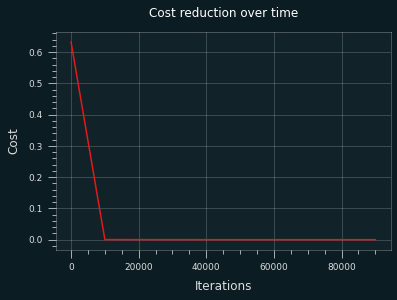

Accuracy: 0.5
MAE: 0.5
Precision: 0.0
Recall: 0.0
F1: 0.0
Prediction time: 0ns
----------------------------------------------------------------------------------------------------------------
Accuracy: 0.3333333333333333
MAE: 0.6666666666666666
Precision: 0.5
Recall: 0.5
F1: 0.5
Prediction time: 0ns
----------------------------------------------------------------------------------------------------------------
Confusion Matrix


c:\Users\Sean\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


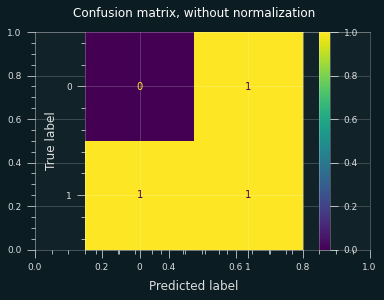

True Negatives:  0
False Positives:  1
False Negatives:  1
True Positives:  1


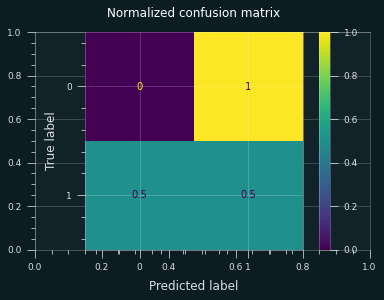

True Negatives:  0.0
False Positives:  1.0
False Negatives:  0.5
True Positives:  0.5
----------------------------------------------------------------------------------------------------------------
Precision Recall Curve


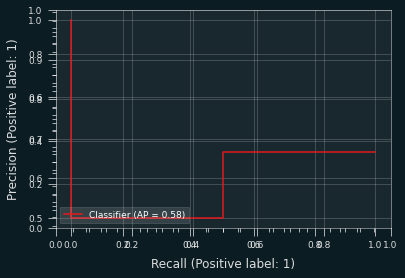

----------------------------------------------------------------------------------------------------------------
ROC Curve


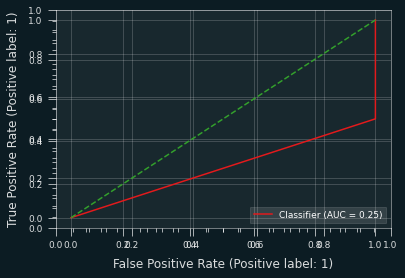

In [124]:
from sklearn.model_selection import train_test_split
X, y, _ = make_spam_dataset()
#split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#train model
weightsFinal, betaFinal = modelTrain(X_train, y_train, 0.1, lamda=0, iterations=100000, test_size=0.4, random_state=42, regularisation=0)
#test model
evalModel(X_test, y_test, weightsFinal, betaFinal, plot=True)